In [ ]:
!pip install ib_async

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time
os.environ['TZ'] ='America/New_York'

#import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ib_async import *
util.startLoop()

### Data Prep for Inferencing

In [ ]:
ib = IB()
ib.connect(port=7496, clientId=1)

In [ ]:
contract = Contract(symbol='META', secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

In [ ]:
contract_vix = Contract(symbol= 'VIX', secType = 'IND',exchange = 'CBOE', currency='USD')
ib.qualifyContracts(contract_vix)

In [ ]:
contract_nas = Contract(symbol= 'TQQQ', secType = 'STK',exchange = 'SMART', currency='USD')
ib.qualifyContracts(contract_nas)

In [2]:
def get_fridays_in_range(start_date, end_date):
    """
    Returns a list of dates that are Fridays within the given date range.

    Args:
        start_date (date): The start date of the range.
        end_date (date): The end date of the range.

    Returns:
        list: A list of date objects representing Fridays within the range.
    """
    fridays = []
    all_dates = []
    current_date = start_date
    all_current_date = start_date

    # Adjust to the first Friday
    days_until_friday = (4 - current_date.weekday()) % 7
    current_date += timedelta(days=days_until_friday)

    while current_date <= end_date:
        fridays.append(current_date)
        current_date += timedelta(days=7) # Move to the next Friday

    while all_current_date <= end_date:
        all_dates.append(all_current_date)
        all_current_date += timedelta(days=1)

    biz_dates = [ d for d in all_dates if d.weekday()<5]
    
    return fridays, biz_dates

# Example Usage
start_date = date(2024, 2, 1)
end_date = date(2025, 4, 8)

fridays, all_dates = get_fridays_in_range(start_date, end_date)
# removing Non-trading Holidays

fridays.remove(date(2024, 3, 29))
fridays.remove(date(2024, 11, 29))

#all_dates.remove(date(2024, 1, 15))
all_dates.remove(date(2024, 2, 19))
all_dates.remove(date(2024, 3, 29))
all_dates.remove(date(2024, 5, 27))
all_dates.remove(date(2024, 6, 19))
all_dates.remove(date(2024, 7, 3))
all_dates.remove(date(2024, 7, 4))
all_dates.remove(date(2024, 9, 2))
all_dates.remove(date(2024, 11, 28))
all_dates.remove(date(2024, 11, 29))
all_dates.remove(date(2024, 12, 24))
all_dates.remove(date(2024, 12, 25))

all_dates.remove(date(2025, 1, 1))
all_dates.remove(date(2025, 1, 8))
all_dates.remove(date(2025, 1, 20))
all_dates.remove(date(2025, 2, 17))


In [ ]:
# duration is fixed for an year
def simple_data_req( contract, end_date , barsize ="1 min", data_clean = True):

   
    df_acc=pd.DataFrame()
    df_hist=pd.DataFrame()

    for i in range(17):
        print(f'fetching data for {i}')
        bars = ib.reqHistoricalData(contract= contract, endDateTime=end_date, barSizeSetting= barsize, durationStr= "20 D", whatToShow="TRADES", useRTH=True)
        df = util.df(bars)
        end_date = end_date - timedelta(20+2)
        df_acc = pd.concat([df, df_acc], ignore_index=True)
        print(f"head date {df_acc.head(1)['date']}")
        print(f"tail date {df_acc.tail(1)['date']}")
        #print(df)

        df_acc['Date_Only'] = df_acc['date'].dt.date
    
    if data_clean == True:
        df_hist = df_acc[(df_acc['date'].dt.time >= time(9, 30)) & (df_acc['date'].dt.time < time(16, 00))]
    else:
        df_hist = df_acc

    #df_hist.drop_duplicates(inplace=True)
    
    return df_hist

In [3]:
# picking out Friday and before specific-time data

#specific_time = time(14, 30, 0)
def data_filter_v46(df_initial, list_days, specific_time_before = None, specific_time_after= None, on_time= None):
    his_df = pd.DataFrame()

    df_trimmed = df_initial[df_initial['date'].dt.date.isin(list_days)]

    if specific_time_before is not None:

        his_df = df_trimmed[(df_trimmed['date'].dt.time < specific_time_before)]
        
            
    if specific_time_after is not None:

        his_df = df_trimmed[(df_trimmed['date'].dt.time >= specific_time_after)]

    if on_time is not None:
        his_df = df_trimmed[(df_trimmed['date'].dt.time == on_time)]

    if (specific_time_before is None and specific_time_after is None) and on_time is None:

        his_df = df_trimmed
        
    return his_df

In [4]:
from datetime import date, timedelta

def calculate_business_days(start_date, end_date):
    """
    Calculates the number of business days between two dates, excluding weekends.

    Args:
        start_date (date): The start date.
        end_date (date): The end date.

    Returns:
        int: The number of business days.
    """
    business_days = 0
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday to Friday
            business_days += 1
        current_date += timedelta(days=1)
    return business_days

# Example usage:
# start_date = date(2025, 2, 1)  # April 7, 2025 (Monday)
# end_date = date(2025, 4, 3)  # April 18, 2025 (Friday)
# num_business_days = calculate_business_days(start_date, end_date)
# print(f"Number of business days between {start_date} and {end_date}: {num_business_days}")

In [5]:
df_META = pd.read_pickle('META_master_stock_info.pkl')
df_VIX = pd.read_pickle('VIX_master_info.pkl')
df_TQQQ = pd.read_pickle('TQQQ_master_info.pkl')

### Trainning Data Set Collection ###

In [ ]:
barsize ="5 mins"

df_all_days_stock = simple_data_req(contract = contract, end_date = end_date, barsize= barsize )

In [ ]:
#df_META = pd.read_pickle('META_master_stock_info.pkl')
df_VIX = pd.read_pickle('VIX_master_info.pkl')
df_TQQQ = pd.read_pickle('TQQQ_master_info.pkl')

In [6]:

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculates the MACD indicator for a given time series data.

    Args:
        data (pd.Series): Time series data (e.g., closing prices).
        fast_period (int): Period for the fast EMA (default: 12).
        slow_period (int): Period for the slow EMA (default: 26).
        signal_period (int): Period for the signal line EMA (default: 9).

    Returns:
        pd.DataFrame: DataFrame containing MACD, signal line, and histogram.
    """
    fast_ema = data.ewm(span=fast_period, adjust=False).mean()
    slow_ema = data.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line

    macd_df = pd.DataFrame({
        'MACD': macd_line,
        'Signal_Line': signal_line,
        'Histogram': histogram
    })
    return macd_df

# Example usage with sample data
#data = pd.Series(np.random.rand(100))
data = df_META['close']
df_META['MACD']= calculate_macd(data)['MACD']
df_META['diff_MACD'] = df_META['MACD'].diff()
df_META['MACD_Sig'] =calculate_macd(data)['Signal_Line']
df_META['diff_M_Sig'] = df_META['MACD_Sig'].diff()
#print(macd_result)

In [ ]:
df_META

In [7]:
import pandas as pd

def calculate_rsi(data, period=12):
    """
    Calculates the Relative Strength Index (RSI) for a given dataset.

    Args:
        data (pd.Series): A Pandas Series representing the price data.
        period (int, optional): The lookback period for calculating RSI. Defaults to 14.

    Returns:
        pd.Series: A Pandas Series containing the RSI values.
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Example usa#ge:
#data = pd.Series([45.49, 45.71, 46.14, 46.13, 45.53, 45.81, 46.44, 46.09, 46.08, 46.71])
#rsi_values = calculate_rsi(data)
#print(rsi_values)

In [8]:
df_META['RSI_12'] = calculate_rsi(df_META['close'])

In [9]:
### data cleaning ## step
# clean duplicate
# is in the days of interest
# within windows

def data_cleaning(df, in_days):
    df_his = pd.DataFrame()
    df_return = pd.DataFrame()
    
    df.drop_duplicates(inplace = True)
    df_his = df[df["Date_Only"].isin(in_days)]
    df_return = df_his[(df_his['date'].dt.time > time(9,29)) & (df_his['date'].dt.time < time(16,00))]

    for i in df_return['Date_Only'].unique():
        if df_return[df_return['Date_Only'] ==i].shape[0] % 390 != 0:
            print(i)
    
    return df_return

In [10]:
df_META = data_cleaning(df_META, all_dates)

df_META.shape

(100620, 14)

In [11]:
df_TQQQ_trim = data_cleaning(df_TQQQ, all_dates)

df_TQQQ_trim.shape

(100620, 9)

In [12]:
df_VIX_trim = data_cleaning(df_VIX, all_dates)

df_VIX_trim.shape

2025-04-08


(100597, 9)

In [13]:
df_META

,date,open,high,low,close,volume,average,barCount,Date_Only,MACD,diff_MACD,MACD_Sig,diff_M_Sig,RSI_12
0,2024-03-22 09:30:00-04:00,507.00,507.38,505.52,506.03,99707.0,506.833,172,2024-03-22,0.000000,NaN,0.000000,NaN,NaN
1,2024-03-22 09:31:00-04:00,506.00,506.30,505.33,505.86,18062.0,505.705,115,2024-03-22,-0.013561,-0.013561,-0.002712,-0.002712,NaN
2,2024-03-22 09:32:00-04:00,505.65,505.89,504.61,504.84,25951.0,505.025,176,2024-03-22,-0.105399,-0.091838,-0.023250,-0.020537,NaN
3,2024-03-22 09:33:00-04:00,504.65,505.63,504.50,505.25,15252.0,505.088,117,2024-03-22,-0.143444,-0.038045,-0.047289,-0.024039,NaN
4,2024-03-22 09:34:00-04:00,505.28,505.31,504.52,504.60,20420.0,504.865,110,2024-03-22,-0.223469,-0.080025,-0.082525,-0.035236,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132055,2025-04-08 15:55:00-04:00,509.65,509.65,505.24,508.04,126395.0,507.204,864,2025-04-08,-0.191831,0.096203,-0.766965,0.143784,53.701016
132056,2025-04-08 15:56:00-04:00,508.09,508.98,507.59,508.88,85229.0,508.218,688,2025-04-08,-0.047263,0.144568,-0.623025,0.143940,67.375307
132057,2025-04-08 15:57:00-04:00,508.93,509.71,508.76,509.15,125106.0,509.145,1088,2025-04-08,0.088079,0.135342,-0.480804,0.142221,66.071429
132058,2025-04-08 15:58:00-04:00,509.25,509.75,508.76,509.57,95853.0,509.303,830,2025-04-08,0.226617,0.138538,-0.339320,0.141484,71.653543


In [15]:
cut_time = time(12, 1, 0)

In [20]:

def data_sparcing_construc(df, sp_day, *, cut_time = None):
    #df_group = df.groupby("Date_Only").std(numeric_only=True)
    df_filter_prior = data_filter_v46(df, sp_day, specific_time_before = cut_time )
    df_group_prior = df_filter_prior.groupby("Date_Only").std(numeric_only=True)
    
    df_filter_after = data_filter_v46(df, sp_day, specific_time_after = cut_time )
    df_group_after = df_filter_after.groupby("Date_Only").std(numeric_only=True)


    df_group_train =pd.DataFrame()
    df_group_train['Target_std'] = pd.DataFrame(df_group_after[['open','high','low','close']].max(axis=1))
    df_group_train['Target_spread'] = df_filter_after.groupby('Date_Only')['open'].max() - df_filter_after.groupby('Date_Only')['open'].min()

    
    
    df_group_train['prior_std'] = pd.DataFrame(df_group_prior[['open','high','low','close']].max(axis=1))
    df_group_train['prior_Vol'] = pd.DataFrame(df_filter_prior.groupby("Date_Only").mean()['volume'])
    df_group_train['prior_spread'] = df_filter_prior.groupby('Date_Only')['open'].max() - df_filter_prior.groupby('Date_Only')['open'].min()

    df_group_train['prev_day_spred'] = df_group_train["Target_spread"].shift(1)
    df_group_train = df_group_train.fillna(df_group_train['prior_spread'].iloc[0])

    
    df_group_train['prior_range'] =pd.DataFrame(df_filter_prior.groupby('Date_Only')['close'].max() -df_filter_prior.groupby('Date_Only')['close'].min() )
    
    df_initial = df_filter_prior.copy()
    new_time = time(cut_time.hour, cut_time.minute -1)
    df_group_train['cut_open'] = df_filter_prior[(df_filter_prior['date'].dt.time == new_time)]['open'].values
    df_group_train['MACD'] = df_filter_prior[(df_filter_prior['date'].dt.time == new_time)]['MACD'].values
    df_group_train['MACD_Sig'] = df_filter_prior[(df_filter_prior['date'].dt.time == new_time)]['MACD_Sig'].values
    df_group_train['RSI_12'] = df_filter_prior[(df_filter_prior['date'].dt.time == new_time)]['RSI_12'].values

    cut_name =['cut_1hr','cut_2hr','cut_3hr']
    for i in range(2):
        print(i)
        prior = time(cut_time.hour - (i+1), cut_time.minute)
        df_group_train[cut_name[i]] = df_initial[(df_initial['date'].dt.time == new_time)]['open'].values- df_initial[(df_initial['date'].dt.time == prior)]['open'].values


    
    return df_group_train, df_filter_prior, df_filter_after, df_group_prior, df_group_after
    

In [21]:
df_group_train, df_filter_prior, df_filter_after, df_group_prior, df_group_after = data_sparcing_construc(df_META, all_dates, cut_time= cut_time)

0
1


In [ ]:
# df_VIX_check = df_all_days_VIX[(df_all_days_VIX['date'].dt.time > time(9,29)) & (df_all_days_VIX['date'].dt.time < time(16,00))]

In [46]:
list_cut_time = [time(12, 1, 0),time(13, 1, 0),time(14, 1, 0), time(15, 1, 0)]

In [47]:
pr_spread = pd.DataFrame()

for i in list_cut_time:
    cut_time= i
    df_group_train, df_filter_prior, df_filter_after, df_group_prior, df_group_after = data_sparcing_construc(df_META, all_dates, cut_time= cut_time)
    pr_spread = pd.concat([pr_spread, df_group_train['Target_spread']], axis=1)


0
1
0
1
0
1
0
1


In [48]:
pr_spread.columns = ["12", "1","2","3"]

In [56]:
pr_spread.mean()

12    7.858566
1     6.585000
2     5.254845
3     3.921357
dtype: float64

<Axes: >

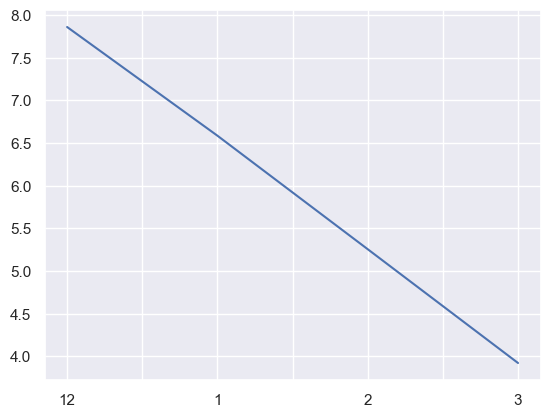

In [51]:
pr_spread.mean().plot()

In [50]:
pr_spread.std()

12    4.356016
1     3.847667
2     3.268401
3     2.399188
dtype: float64

<Axes: >

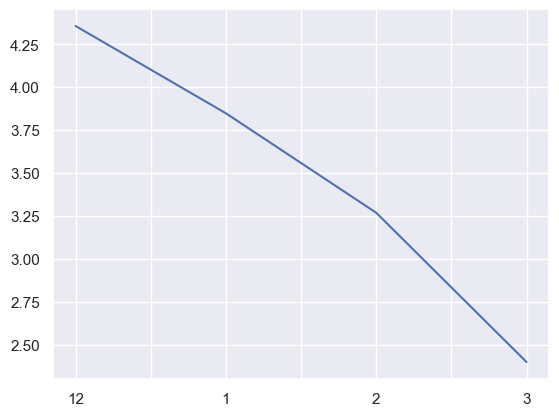

In [53]:
pr_spread.std().plot()

<Axes: xlabel='Target_spread', ylabel='Proportion'>

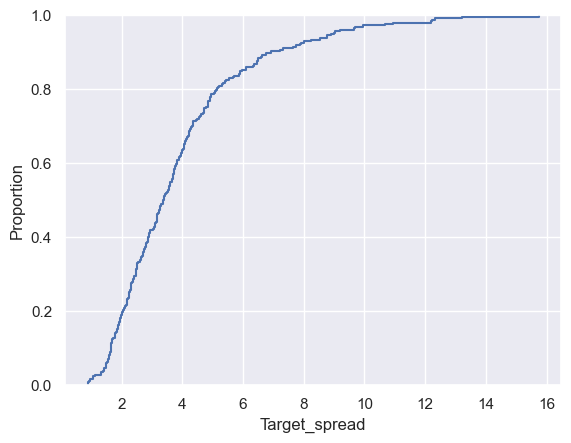

In [59]:
sns.ecdfplot(df_group_train.Target_spread)

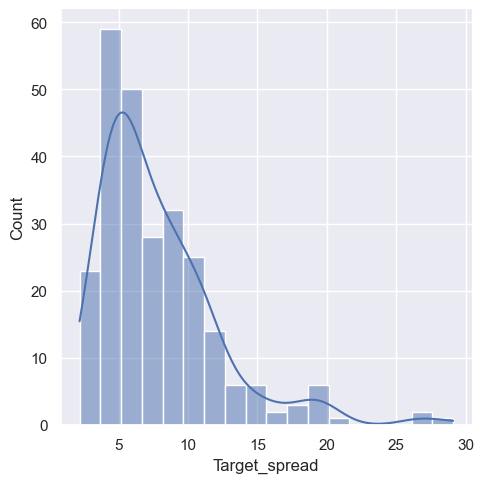

In [33]:
sns.displot(df_group_train.Target_spread, kde=True)

AttributeError: Rectangle.set() got an unexpected keyword argument 'fit'

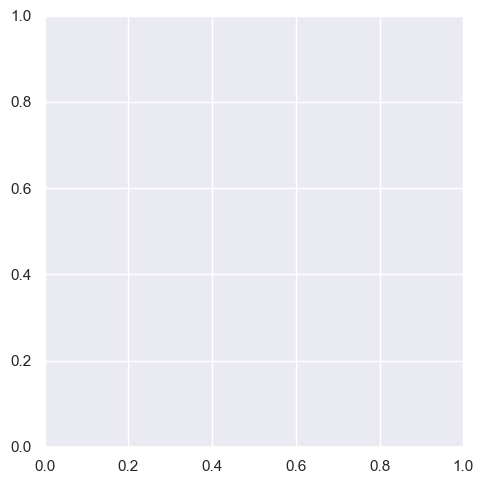

In [31]:
sns.displot(df_group_train.Target_spread, kde=True, fit=stats.norm) # Fits a normal distribution

AttributeError: Rectangle.set() got an unexpected keyword argument 'fit'

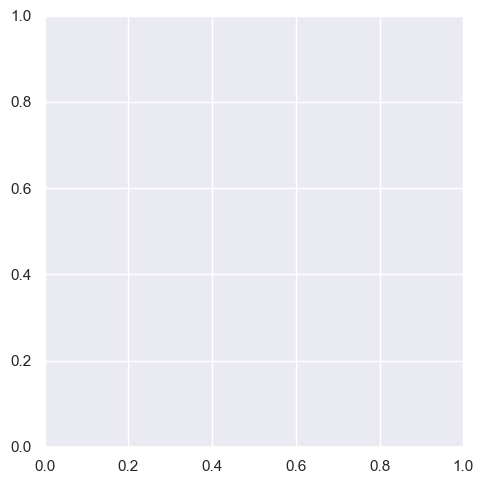

In [30]:
import scipy.stats as stats

sns.displot(df_group_train.Target_spread, kde=True, fit=stats.gamma, fit_kws={"loc":0}) # Fixes the location parameter of the Gamma distribution to 0.

<Axes: ylabel='Frequency'>

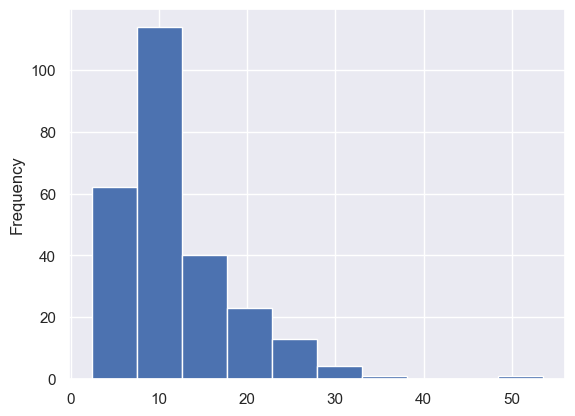

In [26]:
sns.set()
df_group_train['prior_spread'].plot.hist()

In [ ]:
# for d in biz_dates:
#     for df in df_TQQQ_clean:
#         if len(df_TQQQ_clean[df_TQQQ_clean['Date_Only']==d]) !=390:
#             print(d)

In [ ]:
# # switching
# df_VIX = pd.DataFrame()
# df_VIX = df_VIX_clean.copy()

# df_TQQQ = pd.DataFrame()
# df_TQQQ = df_TQQQ_clean.copy()

# df_all_days_stock = pd.DataFrame()
# df_all_days_stock = df_stock_clean.copy()

In [ ]:
df_group_train_vix, *_  = data_sparcing_construc(df_VIX, all_dates, cut_time= cut_time)
df_group_train_tqqq, *_ = data_sparcing_construc(df_TQQQ, all_dates, cut_time= cut_time)

In [ ]:
df_group_train_vix

In [ ]:
df_final_jointed_vix=pd.DataFrame()
df_final_jointed_all=pd.DataFrame()

df_group_train_vix.columns =['vix_std','vix_spread','vix_prior_std','vix_Vol', 'vix_pr_spread', 'vix_pr_day_spread','vix_prior_range','vix_cut_open','vix_cut_1hr','vix_cut_2hr','vix_cut_3hr']
df_final_jointed_vix = pd.concat([df_group_train,df_group_train_vix], axis=1)
df_group_train_tqqq.columns =['tqqq_std','tqqq_spread','tqqq_prior_std','tqqq_Vol','tqqq_pr_spread', 'tqqq_pr_day_spread','tqqq_prior_range','tqqq_cut_open','tqqq_cut_1hr','tqqq_cut_2hr','tqqq_cut_3hr']
df_final_jointed_all = pd.concat([df_final_jointed_vix,df_group_train_tqqq], axis=1)
df_final_jointed_all.drop(['vix_std','vix_Vol','tqqq_std'], axis=1, inplace=True)

In [ ]:
df_final_jointed_all

In [ ]:
df_final_jointed_all.columns

In [ ]:
df_final_jointed_all.drop(['vix_spread','tqqq_spread'], axis=1, inplace =True)

In [ ]:
df_final_jointed_all.columns

In [ ]:
df_final_jointed_all.to_pickle('META_trainning_master_data.pkl')